# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file.

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts depending on how you perform in the following sections.

To get started, you must make a copy of this template and rename it under this format: **yourUVaID_assignment_1.ipynb**. You will need to submit it with all of your outputs included to Gradecope.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [687]:
"""
Various individuals have wildly different insurance charges, and the hope is these insurance charges are somewhat correlated 
to the characteristics of the individual. It would be extremely useful for many parties if we could more accurately predict 
an individual's insurance charges from some easily accessible personal data like age or if they are a smoker. This dataset contains 
information about various patients including the following explanatory features: age (numerical), sex (categorical), 
BMI (numerical), children (numerical), smoker (categorical), and region (categorical). The goal is to predict the 
charges (numerical) billed by health insurance. This is fundamentally a regression problem, as we will be predicting a continuous
value. Such a model, if it performs well, could be useful for insurance companies to determine the charges for individuals. Beyond
this, it could also be useful for individuals to see if they are being overcharged for their insurance or to help individuals
plan for their future medical expenses.
"""

"\nVarious individuals have wildly different insurance charges, and the hope is these insurance charges are somewhat correlated \nto the characteristics of the individual. It would be extremely useful for many parties if we could more accurately predict \nan individual's insurance charges from some easily accessible personal data like age or if they are a smoker. This dataset contains \ninformation about various patients including the following explanatory features: age (numerical), sex (categorical), \nBMI (numerical), children (numerical), smoker (categorical), and region (categorical). The goal is to predict the \ncharges (numerical) billed by health insurance. This is fundamentally a regression problem, as we will be predicting a continuous\nvalue. Such a model, if it performs well, could be useful for insurance companies to determine the charges for individuals. Beyond\nthis, it could also be useful for individuals to see if they are being overcharged for their insurance or to hel

In [688]:
import os
import numpy as np
import pandas as pd

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [689]:
INSURANCE_CSV_DATA_PATH = "insurance.csv"
insurance_df = pd.read_csv(INSURANCE_CSV_DATA_PATH)
insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [690]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [691]:
# --- (1) How big is your dataset? (in terms of MB) ---
print(f"Approx size of dataset in memory (MB): {insurance_df.memory_usage().sum() / 1024**2:.2f}")
print(f"Approx size of dataset on disk (MB): {os.path.getsize(INSURANCE_CSV_DATA_PATH) / 1024**2:.2f}")

Approx size of dataset in memory (MB): 0.07
Approx size of dataset on disk (MB): 0.05


In [692]:
# --- (2) How many entries does it have? ---
print(f"Number of entries: {len(insurance_df)}")

Number of entries: 1338


In [693]:
# --- (3) How many features does it have? ---
print(f"Number of features: {len(insurance_df.columns)}")
print(f"Number of explanatory features (excluding final prediction): {len(insurance_df.columns) - 1}")

Number of features: 7
Number of explanatory features (excluding final prediction): 6


In [694]:
# --- (4) Does it contain any categorical data? ---
categorical_features_cols = insurance_df.select_dtypes(include=['object']).columns
print(f"Contains categorical data: {'Yes' if len(categorical_features_cols) > 0 else 'No'}")
print(f"All categorical features ({len(categorical_features_cols)}): {categorical_features_cols}")

Contains categorical data: Yes
All categorical features (3): Index(['sex', 'smoker', 'region'], dtype='object')


In [695]:
categorical_features_unique_vals = insurance_df[categorical_features_cols].nunique(dropna=True)
print(f"Number of unique values for each categorical feature:\n{categorical_features_unique_vals}")

Number of unique values for each categorical feature:
sex       2
smoker    2
region    4
dtype: int64


In [696]:
# --- (5) Is there any missing values? ---
counts_null_per_feature = insurance_df.isnull().sum()
null_feature_counts = counts_null_per_feature[counts_null_per_feature > 0]

print(f"Features with missing values ({len(null_feature_counts)}):")
print(null_feature_counts)

Features with missing values (0):
Series([], dtype: int64)


In [697]:
# --- (6) What are some basic statistics you can learn right away about this dataset? ---
insurance_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


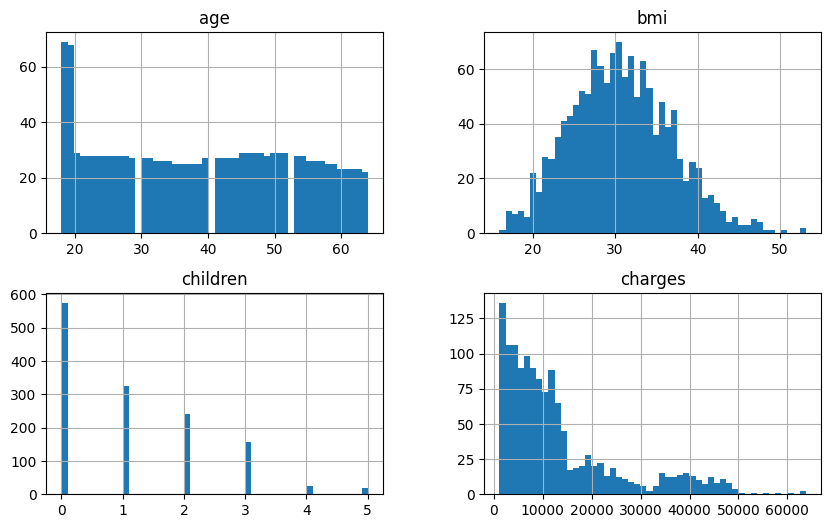

In [698]:
insurance_df.hist(bins=50, figsize=(10,6))
plt.show()

---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class.

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

In [699]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [700]:
corr_matrix = insurance_df.corr(numeric_only=True)
print(corr_matrix.shape)
corr_matrix["charges"].sort_values(ascending=False)

(4, 4)


charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

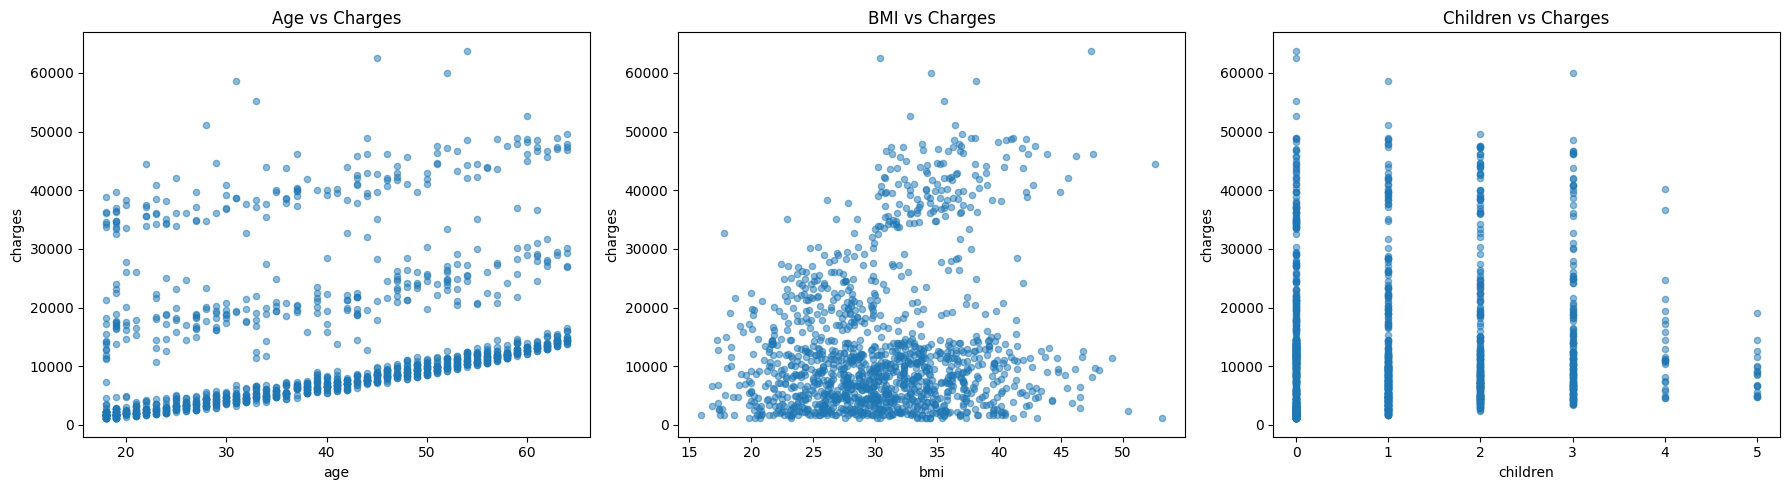

In [701]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

insurance_df.plot(kind="scatter", x="age", y="charges", alpha=0.5, ax=axes[0], title="Age vs Charges")
insurance_df.plot(kind="scatter", x="bmi", y="charges", alpha=0.5, ax=axes[1], title="BMI vs Charges")
insurance_df.plot(kind="scatter", x="children", y="charges", alpha=0.5, ax=axes[2], title="Children vs Charges")

plt.tight_layout()
plt.show()

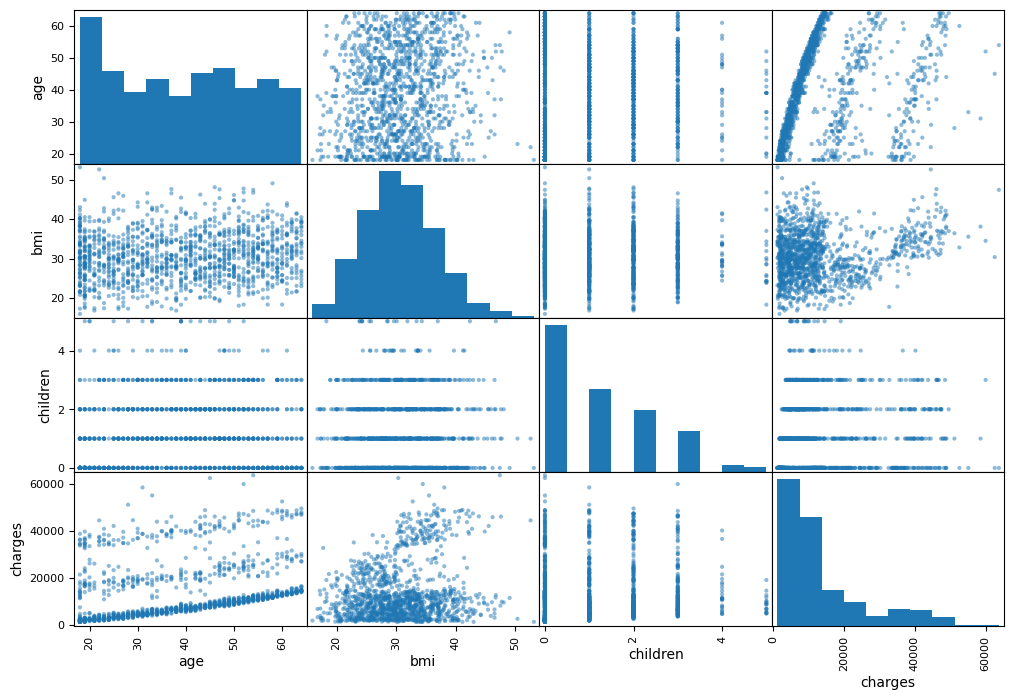

In [702]:
scatter_matrix(insurance_df, figsize=(12, 8))
plt.show()

In [703]:
x_train, x_test, y_train, y_test = train_test_split(
    insurance_df.drop(columns=['charges']), 
    insurance_df['charges'], 
    test_size=0.2, 
    random_state=RANDOM_SEED
)

print(f"Train X shape: {x_train.shape}")
print(f"Train Y shape: {y_train.shape}")
print(f"Test X shape: {x_test.shape}")
print(f"Test Y shape: {y_test.shape}")

Train X shape: (1070, 6)
Train Y shape: (1070,)
Test X shape: (268, 6)
Test Y shape: (268,)


In [704]:
from sklearn.base import BaseEstimator, TransformerMixin

# make feature scaling pipeline with following steps:
# 1) subtract the mean value of each feature from the dataset
# 2) divide each feature by the standard deviation

class CustomScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self._mean = X.mean(axis=0)
        self._std = X.std(axis=0)
        return self

    def transform(self, X, y=None):
        return (X - self._mean) / self._std

In [705]:
num_pipeline = Pipeline([
    ("custom_scaler", CustomScaler()),
])

cat_pipeline = Pipeline([
    # have to drop first to avoid multicollinearity
    ("one_hot_encoder", OneHotEncoder(drop='first')),
])

all_columns_df = insurance_df.drop(columns=["charges"])
combined_pipeline = ColumnTransformer([
    ("num", num_pipeline, all_columns_df.select_dtypes(exclude=["object"]).columns),
    ("cat", cat_pipeline, all_columns_df.select_dtypes(include=["object"]).columns),
])

fit_combined_pipeline = combined_pipeline.fit(x_train)

In [706]:
x_train_prepared = fit_combined_pipeline.transform(x_train)
x_test_prepared = fit_combined_pipeline.transform(x_test)

del x_train, x_test

print(x_train_prepared[0])

[ 0.47200579 -1.75570413  0.73399303  0.          0.          1.
  0.          0.        ]


- - -
## Task 3. IMPLEMENT GRADIENT DESCENT
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods.

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [707]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation
from sklearn.metrics import mean_squared_error

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self, alpha=0.5):
    """
    Initialize the regressor
    """
    self.theta = []
    self.alpha = alpha
    self.cost = lambda true, pred: np.sqrt(mean_squared_error(true, pred))

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    theta = np.random.randn(len(X_train[0]) + 1, 1)
    costs = []
    for i in range(1000):
      theta, cost = self._gradientDescentStep(X_train, y_train, theta)
      costs.append(cost)
      if i % 100 == 0:
        print(f"Cost at iteration {i} is {cost}")
    self.theta = theta.flatten()
    return costs

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    # add x0 = 1 to each instance
    X_b = np.c_[np.ones((len(X_train), 1)), X_train]
    self.theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)

  def _gradientDescentStep(self, X_train, y_train, theta):
    """
    Implementatation of the gradient descent step
    """
    X_b = np.c_[np.ones((len(X_train), 1)), X_train]
    y_train = y_train.reshape(-1, 1)
    gradients = 2/len(X_train) * X_b.T.dot(X_b.dot(theta) - y_train)
    new_theta = theta - self.alpha * gradients
    preds = np.dot(X_b, new_theta)
    return new_theta, self.cost(y_train, preds)

  def predict(self, X_test):
    """
    Predicting the label
    """
    return np.dot(np.c_[np.ones((len(X_test), 1)), X_test], self.theta)

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    return f"Parameter vector is {self.theta}"

# Your code goes here to call the instance of class MyLinearRegression
MyLinearRegression().fitUsingGradientDescent(x_train_prepared, y_train)

Cost at iteration 0 is 12437.003310813458
Cost at iteration 100 is 6105.547322469845
Cost at iteration 200 is 6105.545160176859
Cost at iteration 300 is 6105.545160099849
Cost at iteration 400 is 6105.545160099847
Cost at iteration 500 is 6105.545160099847
Cost at iteration 600 is 6105.545160099847
Cost at iteration 700 is 6105.545160099847
Cost at iteration 800 is 6105.545160099847
Cost at iteration 900 is 6105.545160099847


[np.float64(12437.003310813458),
 np.float64(9835.301561536895),
 np.float64(8491.142498074054),
 np.float64(7728.929069847088),
 np.float64(7250.340693317549),
 np.float64(6926.937139271425),
 np.float64(6699.53312425213),
 np.float64(6536.792620985089),
 np.float64(6419.570508338329),
 np.float64(6334.973790278562),
 np.float64(6273.8888284590885),
 np.float64(6229.754513614705),
 np.float64(6197.827289059169),
 np.float64(6174.681328928367),
 np.float64(6157.848609980253),
 np.float64(6145.555330730426),
 np.float64(6136.52888090356),
 np.float64(6129.857201631883),
 np.float64(6124.886903751332),
 np.float64(6121.149821981758),
 np.float64(6118.310264548264),
 np.float64(6116.127227222579),
 np.float64(6114.427375417765),
 np.float64(6113.085747897787),
 np.float64(6112.011984277949),
 np.float64(6111.140497729337),
 np.float64(6110.423462542248),
 np.float64(6109.825808849164),
 np.float64(6109.321648150376),
 np.float64(6108.89171872545),
 np.float64(6108.521558116945),
 np.float

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

Cost at iteration 0 is 17922.253273726365
Cost at iteration 100 is 14956.02433060028
Cost at iteration 200 is 12997.055217887859
Cost at iteration 300 is 11720.539680570662
Cost at iteration 400 is 10884.834681124305
Cost at iteration 500 is 10322.466449430753
Cost at iteration 600 is 9925.154895121776
Cost at iteration 700 is 9626.58880849499
Cost at iteration 800 is 9387.60635352933
Cost at iteration 900 is 9185.560200131717
Cost at iteration 0 is 17599.309064467197
Cost at iteration 100 is 8988.112894436399
Cost at iteration 200 is 7758.261236286807
Cost at iteration 300 is 7040.235357395167
Cost at iteration 400 is 6627.8015252539
Cost at iteration 500 is 6396.811808201495
Cost at iteration 600 is 6269.219950211443
Cost at iteration 700 is 6199.037375308003
Cost at iteration 800 is 6160.296557855243
Cost at iteration 900 is 6138.689203791376
Cost at iteration 0 is 14562.053871356093
Cost at iteration 100 is 6124.5688979240995
Cost at iteration 200 is 6106.752859211912
Cost at itera

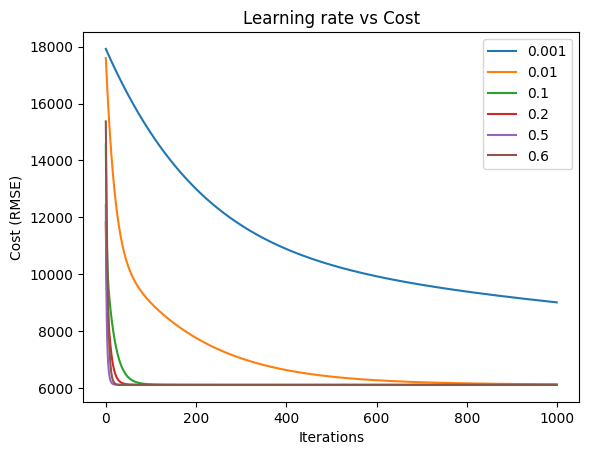

'\nA great learning rate I found to be 0.6, as it converges rather\nquickly to a low value. If you go a bit higher, it quickly diverges.\n'

In [708]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.
curve_0 = MyLinearRegression(alpha=0.001).fitUsingGradientDescent(x_train_prepared, y_train)
curve_1 = MyLinearRegression(alpha=0.01).fitUsingGradientDescent(x_train_prepared, y_train)
curve_2 = MyLinearRegression(alpha=0.1).fitUsingGradientDescent(x_train_prepared, y_train)
curve_3 = MyLinearRegression(alpha=0.2).fitUsingGradientDescent(x_train_prepared, y_train)
curve_4 = MyLinearRegression(alpha=0.5).fitUsingGradientDescent(x_train_prepared, y_train)
curve_5 = MyLinearRegression(alpha=0.6).fitUsingGradientDescent(x_train_prepared, y_train)

plt.plot(range(1000), curve_0, label="0.001")
plt.plot(range(1000), curve_1, label="0.01")
plt.plot(range(1000), curve_2, label="0.1")
plt.plot(range(1000), curve_3, label="0.2")
plt.plot(range(1000), curve_4, label="0.5")
plt.plot(range(1000), curve_5, label="0.6")
plt.title("Learning rate vs Cost")
plt.xlabel("Iterations")
plt.ylabel("Cost (RMSE)")
plt.legend()
plt.show()

"""
A great learning rate I found to be 0.6, as it converges rather
quickly to a low value. If you go a bit higher, it quickly diverges.
"""


- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement:

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [709]:
from sklearn.linear_model import LinearRegression

myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(x_train_prepared, y_train)

myGradientDescentModel = MyLinearRegression(alpha=0.6)
myGradientDescentModel.fitUsingGradientDescent(x_train_prepared, y_train)

lin_reg = LinearRegression()
lin_reg.fit(x_train_prepared, y_train)

normal_equation_predictions = myNormalEquationModel.predict(x_test_prepared)
gradient_descent_predictions = myGradientDescentModel.predict(x_test_prepared)
sklearn_predictions = lin_reg.predict(x_test_prepared)

print(f"\n\n---Model Parameters---\nSklearn Theta == My Normal Equation Theta == My Gradient Descent Theta: {np.isclose(myNormalEquationModel.theta[0], lin_reg.intercept_) and np.allclose(myNormalEquationModel.theta[1:], lin_reg.coef_) and np.allclose(myNormalEquationModel.theta, myGradientDescentModel.theta)}")
print(f"\n---Model Predictions---\nSklearn Predictions == My Normal Equation Predictions == My Gradient Descent Predictions: {np.allclose(normal_equation_predictions, sklearn_predictions) and np.allclose(gradient_descent_predictions, sklearn_predictions)}")

Cost at iteration 0 is 15374.861407078297
Cost at iteration 100 is 6105.545416077804


Cost at iteration 200 is 6105.545160100949
Cost at iteration 300 is 6105.545160099848
Cost at iteration 400 is 6105.545160099848
Cost at iteration 500 is 6105.545160099847
Cost at iteration 600 is 6105.545160099847
Cost at iteration 700 is 6105.545160099847
Cost at iteration 800 is 6105.545160099847
Cost at iteration 900 is 6105.545160099847


---Model Parameters---
Sklearn Theta == My Normal Equation Theta == My Gradient Descent Theta: True

---Model Predictions---
Sklearn Predictions == My Normal Equation Predictions == My Gradient Descent Predictions: True


- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [732]:
from sklearn.metrics import mean_squared_error
import contextlib
import io

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(x_train_prepared, y_train)
y_predict = mySGDModel.predict(x_test_prepared)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print(f"Sklearn SGD Model RMSE: {mySGDModel_rmse}")

# myGradientDescentModel_rmse
gradient_descent_model = MyLinearRegression(alpha=0.6)
with io.StringIO() as buf, contextlib.redirect_stdout(buf):
    gradient_descent_model.fitUsingGradientDescent(x_train_prepared, y_train)
y_predict = gradient_descent_model.predict(x_test_prepared)
mse = mean_squared_error(y_test, y_predict)
myGradientDescentModel_rmse = np.sqrt(mse)
print(f"My Gradient Descent Model RMSE: {myGradientDescentModel_rmse}")

# myNormalEquationModel_rmse
normal_equation_model = MyLinearRegression()
normal_equation_model.fitUsingNormalEquation(x_train_prepared, y_train)
y_predict = normal_equation_model.predict(x_test_prepared)
mse = mean_squared_error(y_test, y_predict)
myNormalEquationModel_rmse = np.sqrt(mse)
print(f"My Normal Equation Model RMSE: {myNormalEquationModel_rmse}")

Sklearn SGD Model RMSE: 5807.982486050612
My Gradient Descent Model RMSE: 5796.284659276274
My Normal Equation Model RMSE: 5796.2846592762735


- - -
## Task 6. PRESENT YOUR SOLUTION

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following:

* How can you pitch your solution to this project?
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

In [711]:
# Your paragraph goes here for this section

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS 4774 Assignment 1:...".

Best of luck and have fun!